In [1]:
import numpy as np
import seissolxdmf as seisx
import pyvista as pv 
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('science')

import sys, os

sys.path.append("../Modules/")

import pv_tools as pvt
from PaperFigGen import *
 
from pTatinPaper_CMaps import *



In [2]:
from Module.GeneralUtils import *

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
FontSizeControlFreak(SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE)

In [3]:
DataPath = '/import/freenas-m-05-seissol/jhayek/EQ_Seissol/MidRes-Result/OutputComplexTurkey/'

ModelName = 'A011'
FaultPath = DataPath + f'{ModelName}-fault.xdmf'


Output = "../Out_Figs/"
FolderOut = Output+ModelName+"/"


try:
   os.makedirs(FolderOut)
except FileExistsError:
   pass



In [4]:
Mesh,ndt = pvt.SeisSol2pyVista.Mesh(FaultPath)


fields_init = ['Td0', 'Ts0', 'Pn0']
fields_final = ['ASl', 'Mud', 'SRs', 'SRd','Vr', 'RT', 'DS', 'Sld', 'Sls']

pvt.SeisSol2pyVista.FieldEnrichment(FaultPath, Mesh, fields_init, 0)
pvt.SeisSol2pyVista.FieldEnrichment(FaultPath, Mesh, fields_final, ndt)

Mesh['FaultTag'] = pvt.SeisSol2pyVista.Get_Tag(FaultPath)
Edges = pvt.pv_processing.GetEdges(Mesh)

Converting SeisSol mesh to pyvista mesh
Connectivity shape: (5174595, 3)
ndt: 42
Converting SeisSol field to pyvista mesh
Available fields {'fault-tag', 'Vr', 'Sls', 'T_s', 'Mud', 'SRs', 'RT', 'DS', 'partition', 'T_d', 'Sld', 'Pn0', 'StV', 'Td0', 'ASl', 'P_n', 'SRd', 'Ts0'}
Converting SeisSol field to pyvista mesh
Available fields {'fault-tag', 'Vr', 'Sls', 'T_s', 'Mud', 'SRs', 'RT', 'DS', 'partition', 'T_d', 'Sld', 'Pn0', 'StV', 'Td0', 'ASl', 'P_n', 'SRd', 'Ts0'}
Get edges


### Fields of interest

In [6]:
Mesh["T0"] = np.linalg.norm(np.stack((Mesh["Ts0"],Mesh["Td0"]),axis=1),axis=1)

In [7]:
ColorLabelMapping.update(dict(TvMuSn = r"$|\tau|-\mu_s|\sigma_n|$" ))

### Scaling fields

In [8]:
MeshScaled = Mesh.copy(deep=True)
MeshScaled.points = MeshScaled.points/1e3



EdgeKwarg = dict(non_manifold_edges=True,manifold_edges=False,feature_edges=False)
Edges = pvt.pv_processing.GetEdges(MeshScaled,EdgeKwarg)



Get edges


# Figures

In [9]:
def PLT_cbar_Annotations(fig,ax,mpl_FieldImg,timestep,ColorLabel, zlabel_pos=(0,160), xlabel_pos=(950,400)):
    axins = Colorbar(fig,ax,mpl_FieldImg, bbox_to_anchor=(0.65,0.5,0.8,0.25))
    axins.set_xlabel(ColorLabel)
    axins.xaxis.set_label_position('top')

    xlabel = "x (km)"
    zlabel = "z (km)" 

    ax.annotate(zlabel,zlabel_pos, xytext=zlabel_pos)
    ax.annotate(xlabel,xlabel_pos, xytext=xlabel_pos)
    ax.annotate(f"Time (s): {timestep}",(0,130), xytext=(0,130))

    ax.axis(False)

def SetupView(pl, MeshScaled, Cam=['xz',0,0],CamZoom=3.8, depth_bound = -50):
    _ = pl.show_grid(grid='back',
        location='outer',
        ticks='both',
        n_xlabels=6,
        n_ylabels=3,
        n_zlabels=3,
        fmt='{:.0f}',
        bold=False,
        show_zaxis= False,    show_yaxis=True,     show_xaxis=True,
        font_size = 14,
        bounds=(0,600,0,300,depth_bound,0),#(400,900,150,500,depth_bound,0),
        xtitle='',ytitle='', ztitle='',use_3d_text=False,
        minor_ticks=False,
        )

    pvt.pvPlots.SetCamera(pl, Cam=Cam,CamZoom=CamZoom)

def WrapperMeshField2Image_Iso(Mesh,Edges,field, Cam=['xz',20,40], CamZoom=1.2,depth_bound=-80,**kwargs):

    pl = pv.Plotter(shape=(1, 1),window_size=[1500, 1000],off_screen=True)
    AddMeshField(pl,Mesh,Edges,field,**kwargs)
    SetupView(pl, Mesh, Cam=Cam,CamZoom=CamZoom, depth_bound=depth_bound)
    pl.show()

    Image = pl.image.copy()
    pl.close()
    return Image


def PLT_SingleFaultField(field, MeshScaled, Edges, LabelkwargsUp={}, **kwargs):
    Labelkwargs = dict(timestep=0, nuc_pixel_coordinates = [1265,230],depth_bound=-50,zlabel_pos=(25,90),xlabel_pos=(950,500))
    Labelkwargs.update(LabelkwargsUp)
    
    ImageField = WrapperMeshField2Image_Iso(MeshScaled,Edges,field,depth_bound=Labelkwargs["depth_bound"], **kwargs)


    fig = plt.figure(figsize=(12, 12)) 
    ax = fig.add_subplot()
    mpl_FieldImg = ax.imshow(ImageField,**kwargs)

    PLT_cbar_Annotations(fig,ax,mpl_FieldImg,Labelkwargs["timestep"],ColorLabelMapping[field],zlabel_pos=Labelkwargs["zlabel_pos"],xlabel_pos=Labelkwargs["xlabel_pos"])

    ############################################################################
    # Nucleation marker
    ############################################################################
    #nuckwargs = dict(marker='*', s=100, color="yellow",ec="k",lw=.5)
    #ax.scatter(*Labelkwargs["nuc_pixel_coordinates"], **nuckwargs)

    return  fig,ax

In [10]:
from matplotlib.patches import FancyBboxPatch

def add_text_box(ax, text, x, y, boxstyle="round,pad=0.3", facecolor="white", edgecolor="black"):
    # Create a FancyBboxPatch object
    bbox = dict(boxstyle=boxstyle, facecolor=facecolor, edgecolor=edgecolor)
    ax.text(x, y, text, ha='left', va='top', bbox=bbox, transform=ax.transAxes)


In [11]:
LabelKwargs = dict(depth_bound=-90,zlabel_pos=(75,450),xlabel_pos=(650,860))

LabelKwargsTime = dict(timestep=ndt)
LabelKwargsTime.update(LabelKwargs)

Field FaultTag [3, 66]


/import/freenas-m-02-seismology/jhayek/miniconda3/envs/sx0/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


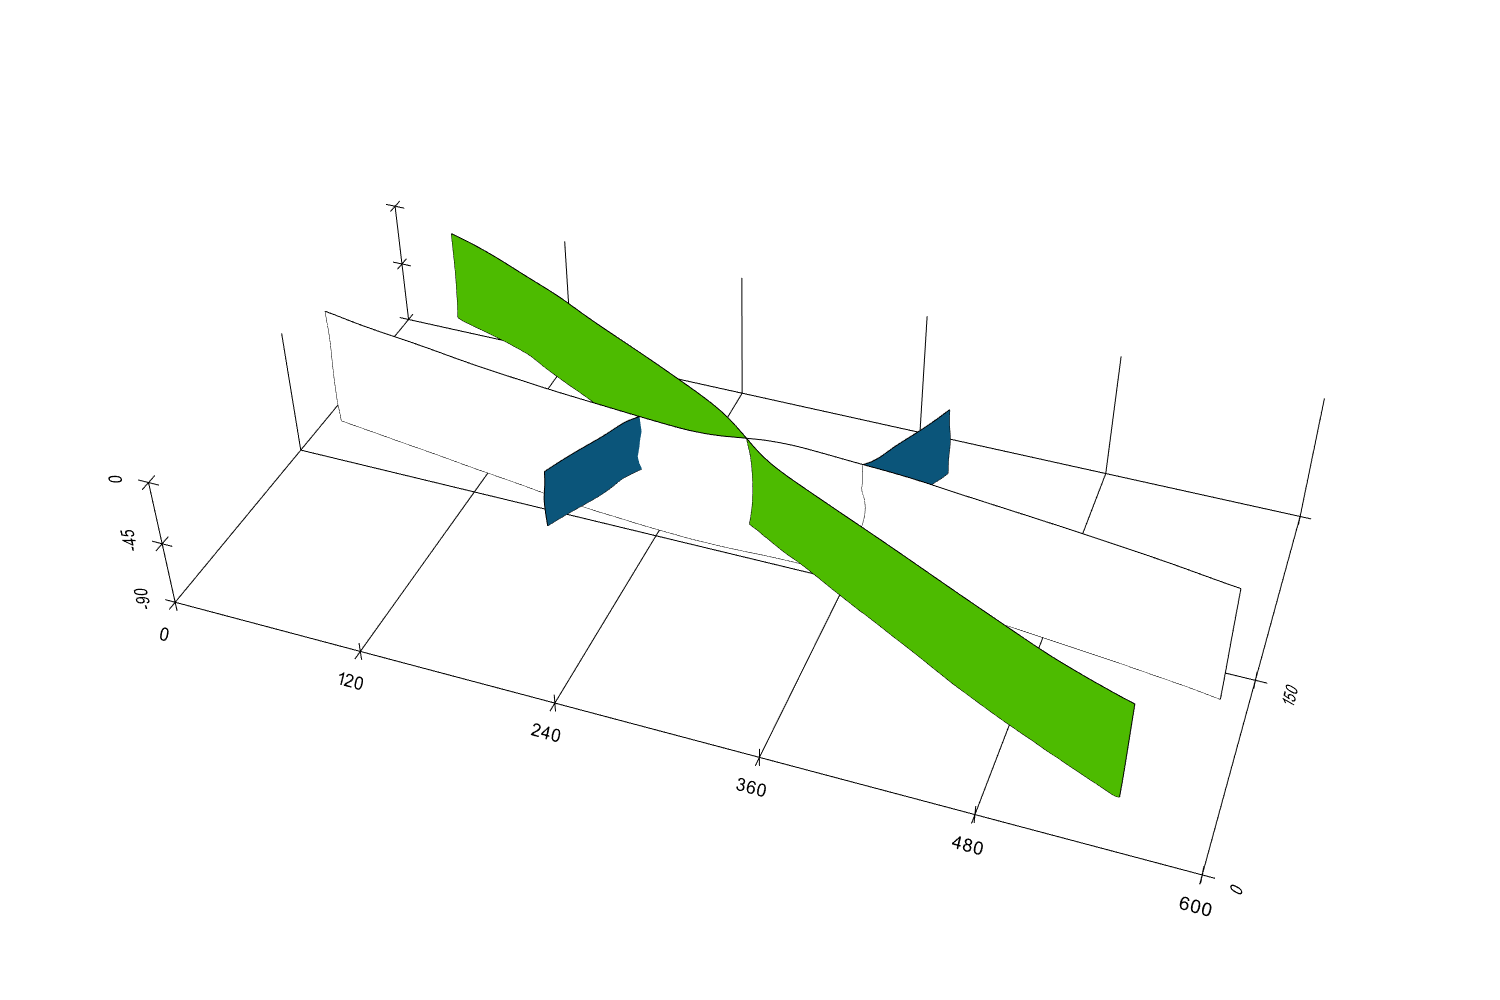

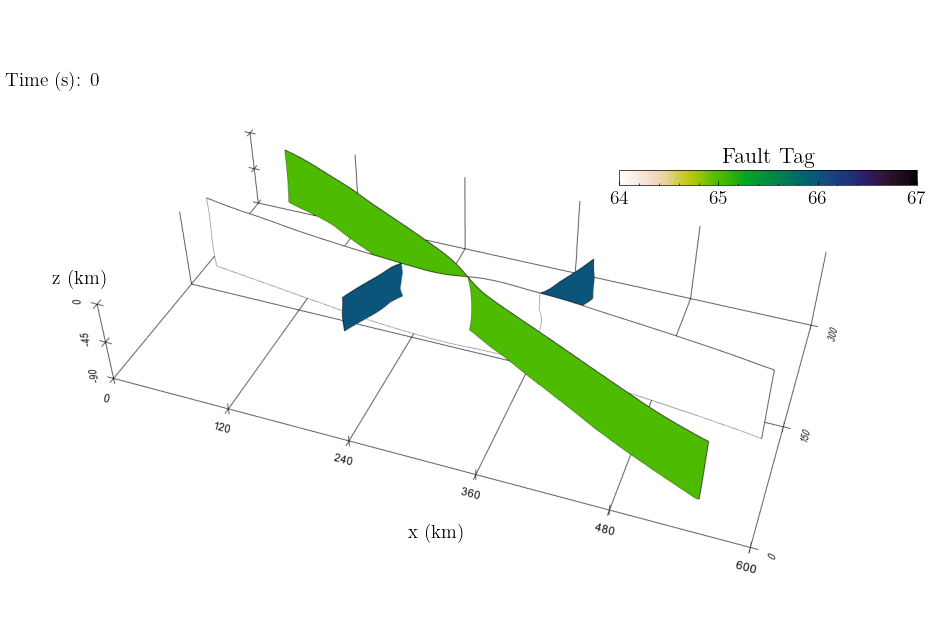

In [12]:
field = 'FaultTag'
print("Field",field,[MeshScaled[field].min(),MeshScaled[field].max()])

kwargs = {'cmap': CmapSR, 
          'clim' : [64,67],
          }

fig,ax = PLT_SingleFaultField(field, MeshScaled, Edges,LabelKwargs, **kwargs)



In [13]:

Tag1 = dict(mu_s=0.15,mu_d=0.01,taglist=[3])
Tag2 = dict(mu_s=0.4,mu_d=0.05,taglist=[65])
Tag3 = dict(mu_s=0.25,mu_d=0.05,taglist=[66])
tagwise_SR(MeshScaled,**Tag1)
tagwise_SR(MeshScaled,**Tag2)
tagwise_SR(MeshScaled,**Tag3)




#center = (0.227e6,.14e6,-7.4)
#center = (0.214e6,.111e6,-7.4)
center = (0.214e6,.111e6,-11)



scaledcenter = (center[0]*1e-3,center[1]*1e-3,center[2])
MeshScaled["DistFromEpicenter"] = Filter_Dataset_Around_loc(MeshScaled.points, [scaledcenter])

MeshScaled["Depth"] = MeshScaled.points[:,2:]
MeshScaled["DepthY"] = MeshScaled.points[:,1:2]
MeshScaled["DepthX"] = MeshScaled.points[:,:1]

DepthContourn = MeshScaled.contour(-20+np.array([0]),scalars='Depth')
YContourn = MeshScaled.contour(center[1]*1e-3+np.array([0,5,-5]),scalars='DepthY')
XContourn = MeshScaled.contour(center[0]*1e-3+np.array([0,5,-5]),scalars='DepthX')
EpiContourn = MeshScaled.contour(np.array([1,5]),scalars='DistFromEpicenter')

Max Mu_s for tag: [3] 0.14596032476594886
Max Mu_s for tag: [65] 0.3894972330196298
Max Mu_s for tag: [66] 0.23747544081516136


Field TvMuSn [-426860254.1309582, -88196.05874204217]


/import/freenas-m-02-seismology/jhayek/miniconda3/envs/sx0/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


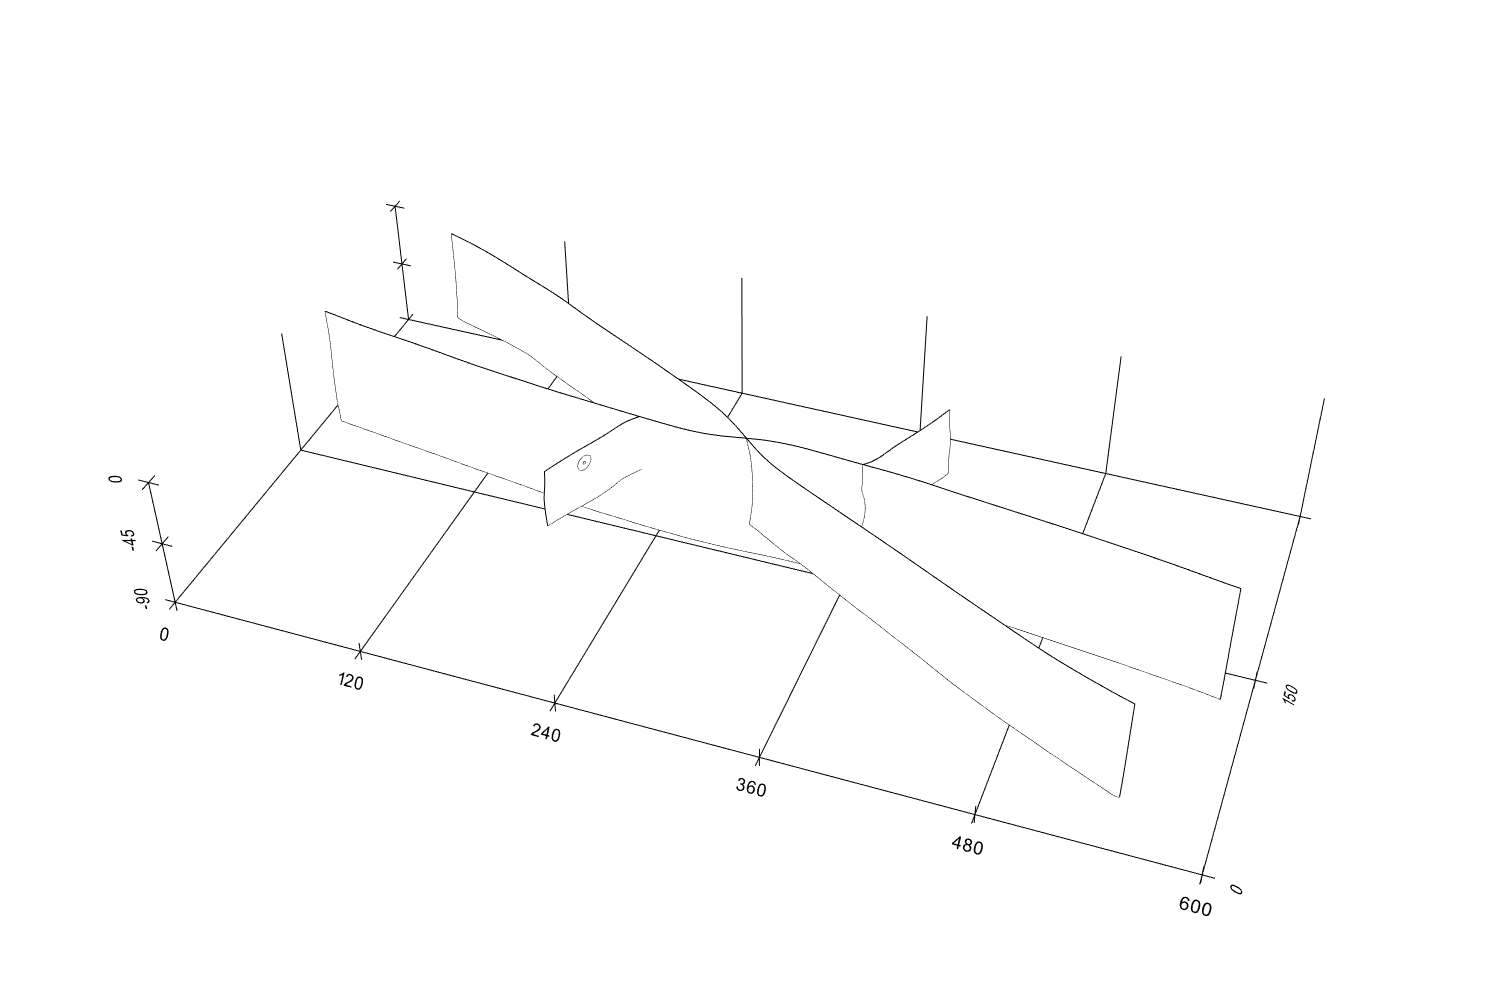

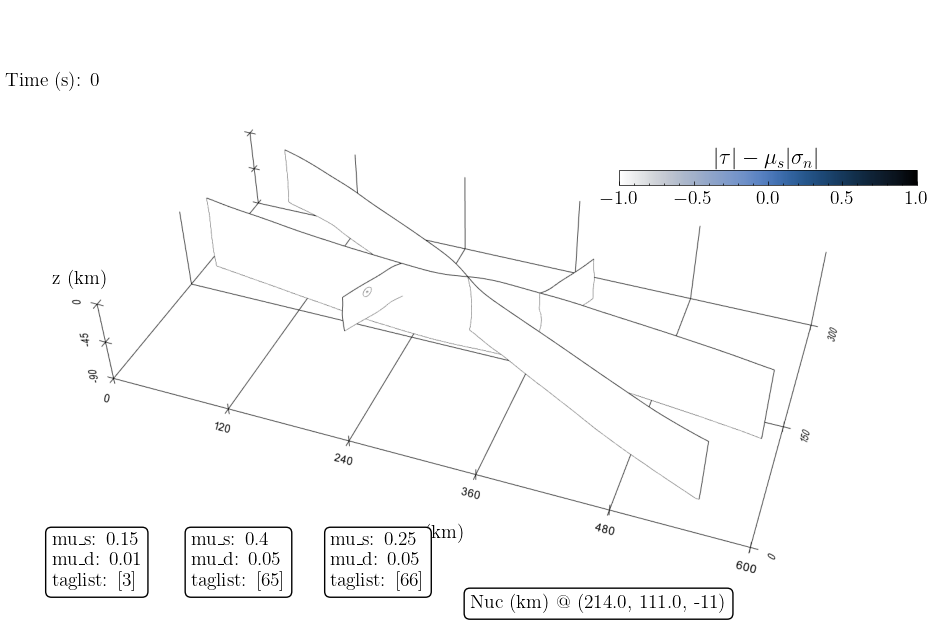

In [14]:
field = 'TvMuSn'
Cbar_range = [MeshScaled[field].min(),MeshScaled[field].max()]
print("Field",field,Cbar_range)

kwargs = {'cmap': CmapRT, 
          'clim' : [-1,1],
          }


fig,ax = PLT_SingleFaultField(field, MeshScaled, Edges+EpiContourn, LabelKwargs, **kwargs)



# Convert dictionaries to formatted text
text1 = "\n".join([f"{key}: {value}" for key, value in Tag1.items()])
text2 = "\n".join([f"{key}: {value}" for key, value in Tag2.items()])
text3 = "\n".join([f"{key}: {value}" for key, value in Tag3.items()])

# Add text boxes to the figure
add_text_box(ax, text1, 0.05, 0.15)  # Top-left corner
add_text_box(ax, text2, 0.2, 0.15)  # Top-right corner
add_text_box(ax, text3, 0.35, 0.15)  # Top-right corner

add_text_box(ax, "Nuc (km) @ "+str(scaledcenter), 0.5, 0.05)


Field R [-0.23568567143223748, 0.9711451768996348]


/import/freenas-m-02-seismology/jhayek/miniconda3/envs/sx0/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


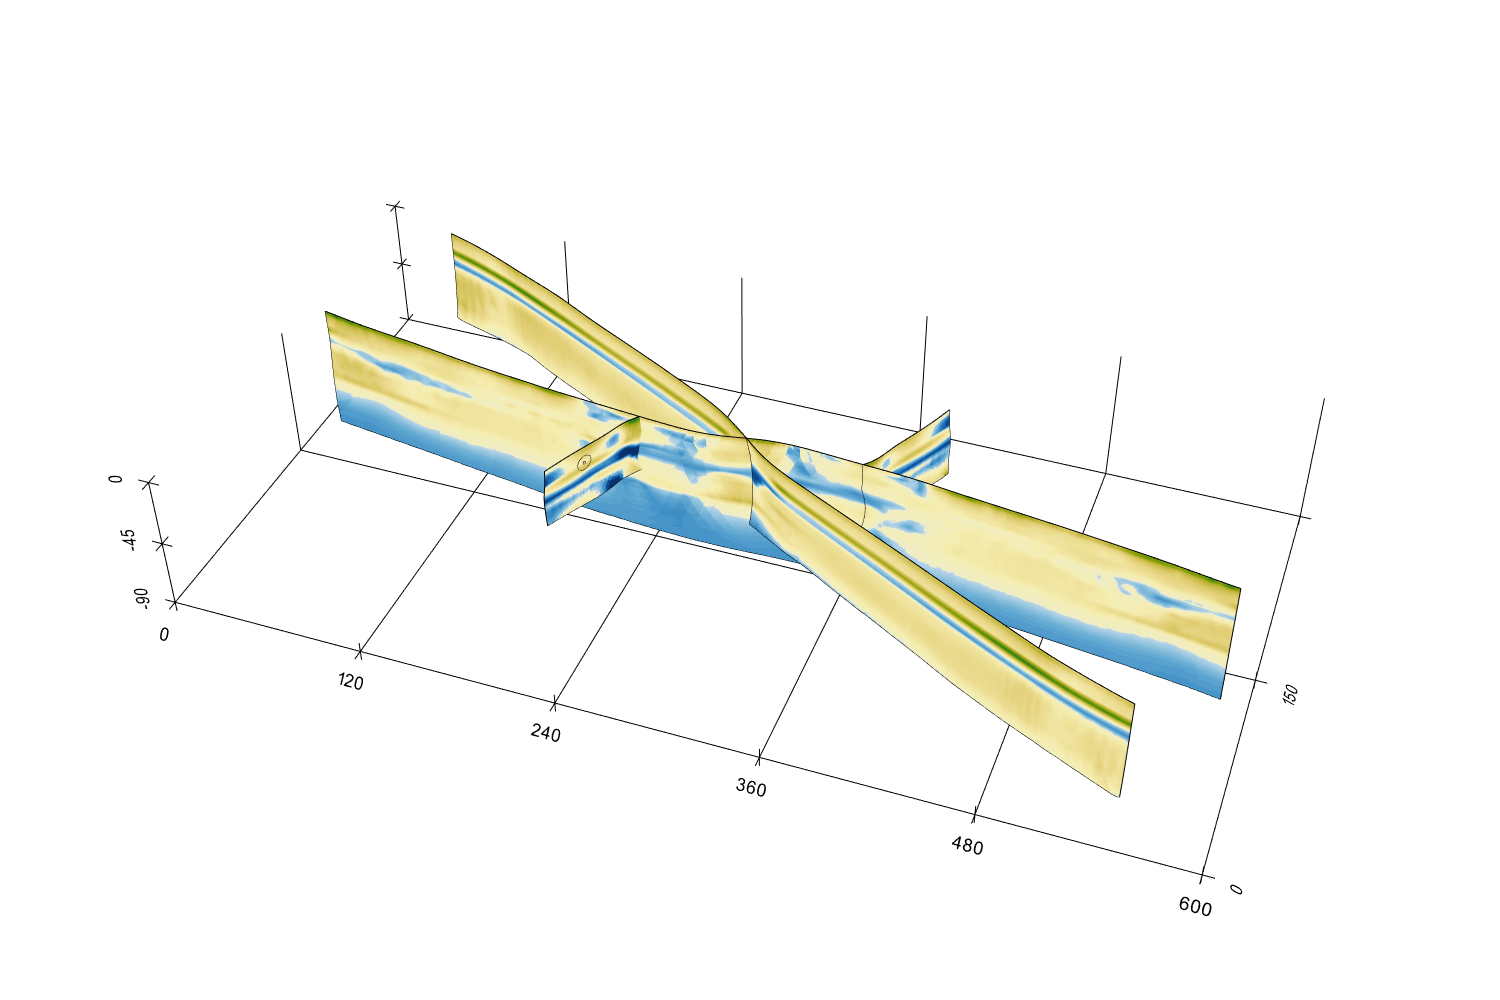

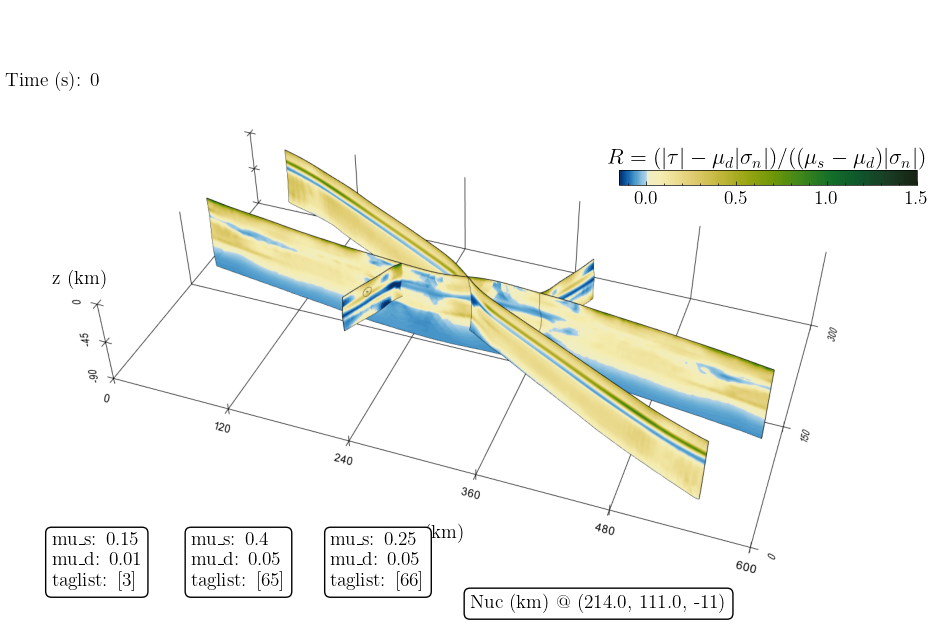

In [15]:
field = 'R'
Cbar_range = [MeshScaled[field].min(),MeshScaled[field].max()]
print("Field",field,Cbar_range)

kwargs = {'cmap': R_param_Cmap, 
          'clim' : [-.15,1.5],
          }


fig,ax = PLT_SingleFaultField(field, MeshScaled, Edges+EpiContourn, LabelKwargs, **kwargs)



# Convert dictionaries to formatted text
text1 = "\n".join([f"{key}: {value}" for key, value in Tag1.items()])
text2 = "\n".join([f"{key}: {value}" for key, value in Tag2.items()])
text3 = "\n".join([f"{key}: {value}" for key, value in Tag3.items()])

# Add text boxes to the figure
add_text_box(ax, text1, 0.05, 0.15)  # Top-left corner
add_text_box(ax, text2, 0.2, 0.15)  # Top-right corner
add_text_box(ax, text3, 0.35, 0.15)  # Top-right corner

add_text_box(ax, "Nuc (km) @ "+str(scaledcenter), 0.5, 0.05)


Field ASl [-0.4195168750067292, 5.562432244232902]


/import/freenas-m-02-seismology/jhayek/miniconda3/envs/sx0/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


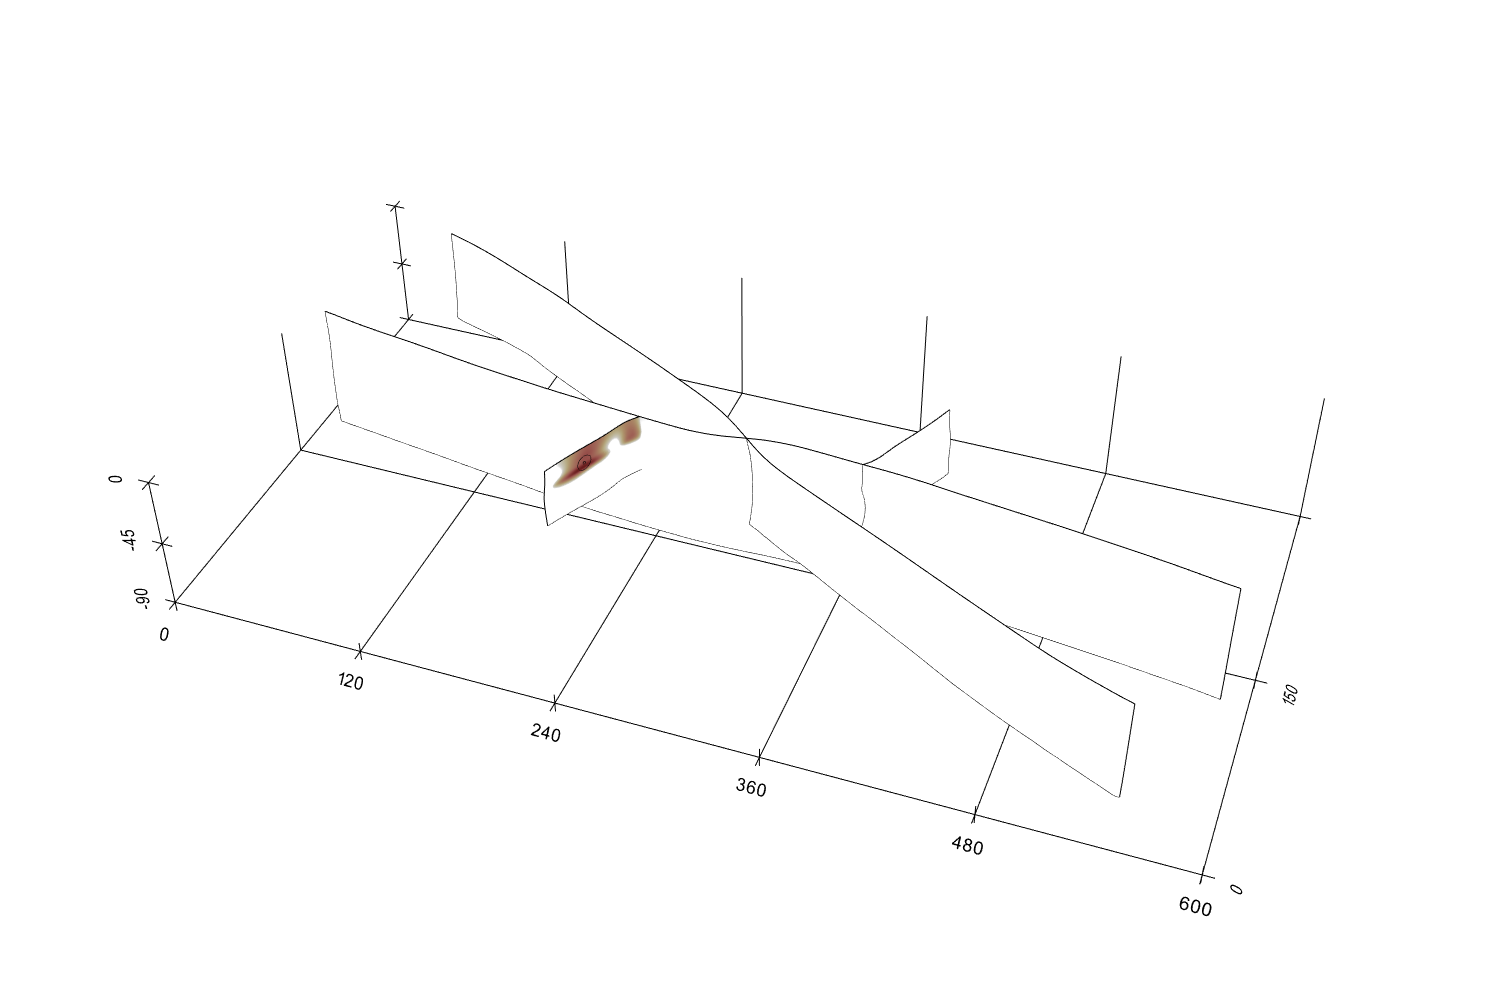

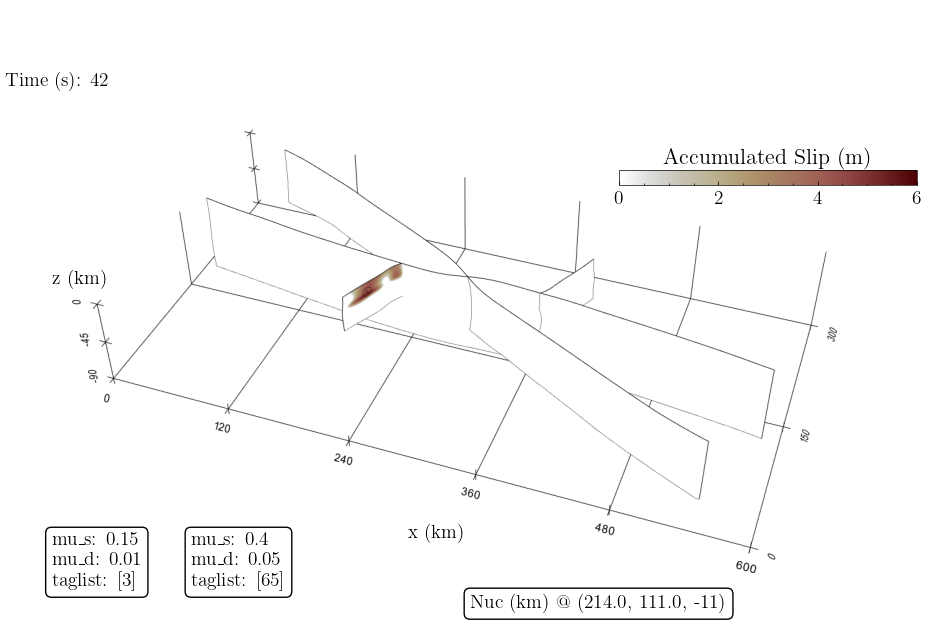

In [16]:
field = 'ASl'
Cbar_range = [MeshScaled[field].min(),MeshScaled[field].max()]
print("Field",field,Cbar_range)

kwargs = {'cmap': CmapSl, 
          'clim' : [0,6],
          }

fig,ax = PLT_SingleFaultField(field, MeshScaled, Edges+EpiContourn, LabelKwargsTime, **kwargs)



# Convert dictionaries to formatted text
text1 = "\n".join([f"{key}: {value}" for key, value in Tag1.items()])
text2 = "\n".join([f"{key}: {value}" for key, value in Tag2.items()])

# Add text boxes to the figure
add_text_box(ax, text1, 0.05, 0.15)  # Top-left corner
add_text_box(ax, text2, 0.2, 0.15)  # Top-right corner

add_text_box(ax, "Nuc (km) @ "+str(scaledcenter), 0.5, 0.05)
